In [1]:
import pandas as pd
import ast
from nltk.tokenize import sent_tokenize
import numpy as np

from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns

!pip install -U sentence-transformers
from sentence_transformers import SentenceTransformer
import logging
from transformers import logging as hf_logging

full_data = pd.read_csv('/kaggle/input/tmdb-movie-metadata/tmdb_5000_movies.csv')

pd.set_option('display.width', 1000)
pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.0/86.0 kB 6.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... - \ done
  Created wheel for sentence-transformers: filename=sentence_transformers-2.2.2-py3-none-any.whl size=125938 sha256=d2fbe53c3c322c3d7b99344ba9eeb883b293d6f1d0c774db54d0d14223755419
  Stored in directory: /root/.cache/pip/wheels/62/f2/10/1e606fd5f02395388f74e7462910fe851042f97238cbbd902f
Successfully built sentence-transformers


In [2]:
# Data Preprocessing
imp_data = full_data[['id', 'overview', 'title', 'keywords']].dropna(subset=['overview'])
imp_data = imp_data[imp_data['overview'] != '']

summaries_small = imp_data['overview'][:4000].reset_index(drop=True)
titles_small = imp_data['title'][:4000].reset_index(drop=True)
ids_small = imp_data['id'].reset_index(drop=True)

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

In [3]:
# BERT Implementation

# SBERT model 'all-mpnet-base-v2'
# https://www.sbert.net/docs/pretrained_models.html#model-overview
model = SentenceTransformer('all-mpnet-base-v2')

# Disable logging from the transformers library
hf_logging.set_verbosity_error()

# Disable logging from the sentence_transformers library
logger = logging.getLogger("sentence_transformers")
logger.setLevel(logging.ERROR)

def sbert_tokenize_and_embed_data(raw_data):
    data = []
    for summary in raw_data:
        sent_embeds = model.encode(sent_tokenize(summary))
        avg_embed = np.mean(sent_embeds, axis=0)
        data.append(avg_embed)
    return data

# tokenize and embed data with SBERT
processed_data = sbert_tokenize_and_embed_data(summaries_small)
print(np.shape(processed_data))

/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: libtensorflow_io.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so: undefined symbol: _ZTVN10tenso

(4000, 768)


In [4]:
from sklearn.cluster import SpectralClustering
from sklearn.metrics import davies_bouldin_score

number_of_clusters = 1000
# Perform clustering with Spectral
clustering = SpectralClustering(n_clusters=number_of_clusters, assign_labels='discretize',random_state=7).fit(processed_data)

# Assign labels to data points
labels = clustering.labels_

# Compute Davies-Bouldin Index
db_score = davies_bouldin_score(processed_data, labels)

print('Davies-Bouldin Index: ', db_score)

Davies-Bouldin Index:  2.4805445367358185


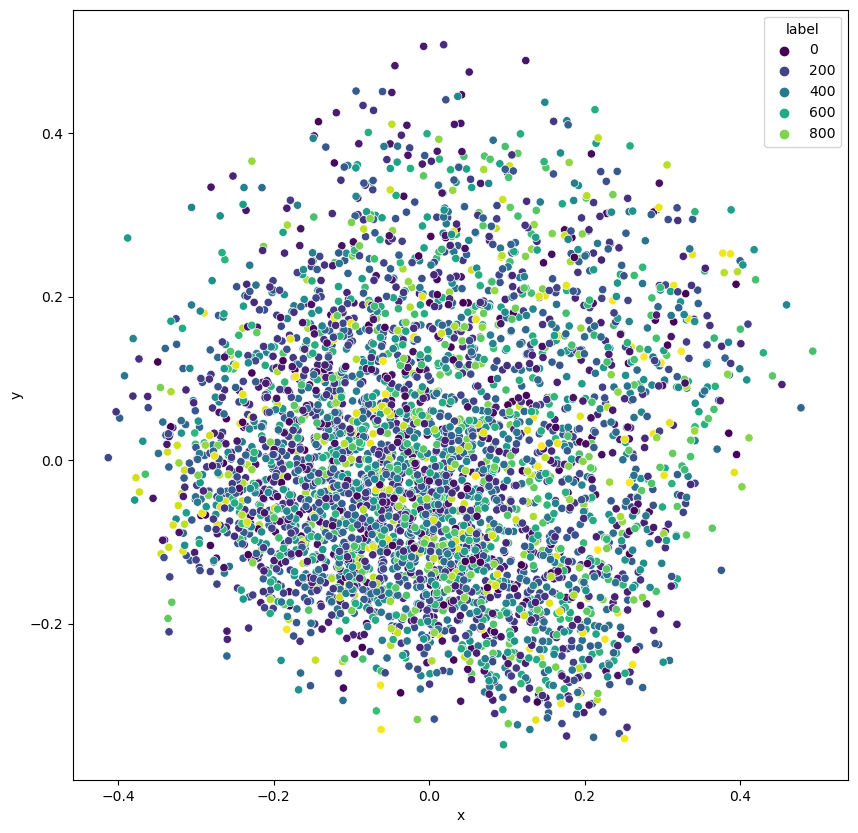

Cluster 0 summaries:
         ID      Title                                            Summary
585   57212  War Horse  Follows a young man named Albert and his horse...
773    9664    Flyboys  The adventures of the Lafayette Escadrille, yo...
1426  14175    Valiant  The animated comedy tells the story of a lowly...


Cluster 1 summaries:
         ID                         Title                                            Summary
1081   4148            Revolutionary Road  A young couple living in a Connecticut suburb ...
3019  39349                    Sugar Hill  Sugar Hill is a 1994 American crime-drama/neo-...
3696  13342  Fast Times at Ridgemont High  Follows a group of high school students growin...
3826  10634                        Friday  Craig and Smokey are two guys in Los Angeles h...


Cluster 2 summaries:
        ID                              Title                                            Summary
347  22794  Cloudy with a Chance of Meatballs  Inventor Flint Lockwood crea

In [5]:
# PCA for dimension reduction
pca = PCA(n_components=2)
reduced_data = pca.fit_transform(processed_data)

# Create a DataFrame for easy plotting
df = pd.DataFrame(reduced_data, columns=['x', 'y'])
df['label'] = clustering.labels_
df['Title'] = titles_small
df['Summary'] = summaries_small
df['ID'] = ids_small

# print(df)

# Plot using seaborn
plt.figure(figsize=(10, 10))
sns.scatterplot(data=df, x='x', y='y', hue='label', palette='viridis', legend=True)
plt.show()

pd.set_option('display.width', 1000)
pd.set_option('display.max_colwidth', 50)

# Print out summaries from each cluster
for i in range(number_of_clusters):  # Change this range depending on which clusters you want to look at
    print(f'Cluster {i} summaries:')
    print(df[df['label'] == i][['ID', 'Title', 'Summary']])
    print('\n')

In [6]:
cluster_counts = df['label'].value_counts()
largest_cluster = cluster_counts.idxmax()
largest_cluster_size = cluster_counts.max()

print(f"The largest cluster is: {largest_cluster} with size: {largest_cluster_size}")

The largest cluster is: 91 with size: 20
